In [35]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState
from src.bf_quantum_state import BFQuantumState

In [36]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [3]:
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()

## Comparison of modified shadows vs original shadows

In [4]:
# 100s for one batch
#modified shadows
qubit_num = 14
batches = 50
some_ratios = np.array([0.1, 1.0])
num_of_measurements = np.array([10, 20, 50, 100, 140])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 140])
meas_methods = ['randomized', 'derandomized']
rel_error_modified = np.zeros((np.size(num_of_measurements), batches, np.size(meas_methods), np.size(some_ratios)))
for s in range(np.size(some_ratios)):
    ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])]
    mps = MPS.from_state_vector(qubit_num, ground_state)
    mps.normalise()
    mps.orth_idx = 0
    mps.canonicalise(qubit_num - 1)
    for l in range(0,2):
        if meas_methods[l] == 'derandomized':
            num_of_measurements = 2 * np.ones(np.size(num_of_measurements))
            num_of_measurements_per_rot = (num_of_measurements * num_of_measurements_per_rot) / 2
        for b in range(batches):
            print('starting batch ' + str(b))
            for i in range(np.size(num_of_measurements)):
                observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[s], 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[i]), int(num_of_measurements_per_rot[i]), meas_methods[l], observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[s], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_methods[l])
                energy = pt.mean(energies)
                energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])][0]
                rel_error_modified[i,b,l,s] = np.abs(energy - energy_brute) / np.abs(energy_brute)

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 20
starting batch 21
starting batch 22
starting batch 23
starting batch 24
starting batch 25
starting batch 26
starting batch 27
starting batch 28
starting batch 29
starting batch 30
starting batch 31
starting batch 32
starting batch 33
starting batch 34
starting batch 35
starting batch 36
starting batch 37
starting batch 38
starting batch 39
starting batch 40
starting batch 41
starting batch 42
starting batch 43
starting batch 44
starting batch 45
starting batch 46
starting batch 47
starting batch 48
starting batch 49
starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting

In [5]:
#unmodified classical shadows
num_of_measurements = np.array([100, 200, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000, 20000])
batches = 50
errors = np.zeros((batches, np.size(num_of_measurements), np.size(meas_methods), np.size(some_ratios)))
for s in range(0, np.size(some_ratios)):
    for l in range(0, 2):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios[s])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios[s])+'_qubit_num_'+str(qubit_num)+'_method_'+meas_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios[s])+'_qubit_num_'+str(qubit_num)+'_method_'+meas_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,some_ratios[s], 1, 'periodic').energy_shadow(None,num_of_measurements[j],meas_methods[l], measurements)
            errors[k,:, l, s] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)

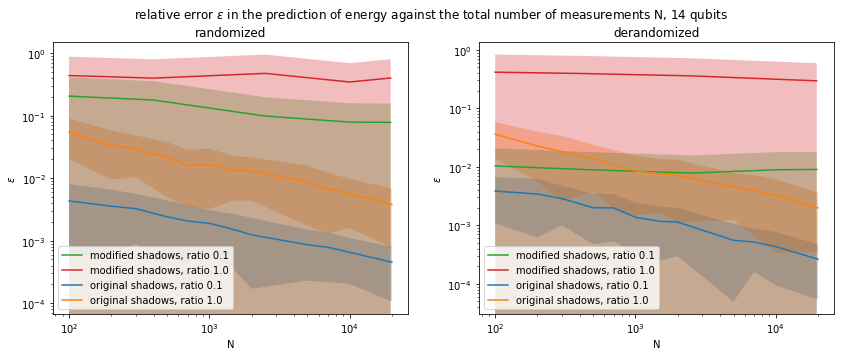

In [22]:
qubit_num = 14
num_of_measurements = np.array([50,100, 200, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000, 20000])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative error $\epsilon$ in the prediction of energy against the total number of measurements N, ' + str(qubit_num) + ' qubits')
error_mean_orig = np.mean(errors, axis=0)
error_std_orig = np.std(errors, axis=0)
for s in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].errorbar(num_of_measurements[1:], error_mean_orig[1:,l, s], label = 'original shadows, ratio ' + str(some_ratios[s]))
        axs[l].fill_between(num_of_measurements[1:], error_mean_orig[1:,l, s] - error_std_orig[1:,l, s], error_mean_orig[1:,l,s] + error_std_orig[1:,l,s], alpha = 0.3)

num_of_measurements = np.array([10, 20, 50, 100, 140])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 140])
rel_error_mean = np.mean(rel_error_modified, axis=1)
rel_error_std = np.mean(rel_error_modified, axis=1)
for s in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s], label='modified shadows, ratio ' + str(some_ratios[s]))
        axs[l].fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s] - rel_error_std[:,l, s], rel_error_mean[:,l,s] + rel_error_std[:,l,s], alpha=0.3)
        axs[l].set(yscale='log', xscale='log', xlabel='N', ylabel='$\epsilon$')
        axs[l].set_title(meas_methods[l])
        axs[l].legend()

## Gradient Estimation with Classical Shadows

In [15]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
qubit_num = 14
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [16]:
# 12 min per batch
# now we estimate the gradient by using the derandomized classical shadows
num_of_measurements = np.array([10, 20, 50, 100, 200])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 200])
batches = 50
some_ratios = np.array([0.1, 1.0])
meas_methods = np.array(['randomized', 'derandomized'])
errors = np.zeros((np.size(num_of_measurements_per_rot), batches, np.size(some_ratios), np.size(meas_methods)))

for l in range(np.size(meas_methods)):
    if meas_methods[l] == 'derandomized':
        num_of_measurements = 2 * np.ones(np.size(num_of_measurements))
        num_of_measurements_per_rot = (num_of_measurements * num_of_measurements_per_rot) / 2
    for h in range(np.size(some_ratios)):
        param_vec_brute = random_param_vec.clone().detach()
        param_vec_brute.requires_grad_(True)
        mps_brute = MPS.from_tensor_list(tensor_liste_rand)
        mps_brute.from_param_vec(param_vec=param_vec_brute)
        mps_brute.normalise()
        mps_brute.orth_idx = 0
        mps_brute.canonicalise(qubit_num - 1)
        psi = mps_brute.to_state_vector()
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').to_matrix().todense())
        energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        energy_bf.backward()

        for b in range(0, batches):
            print('starting batch ' + str(b))
            for j in range(np.size(num_of_measurements_per_rot)):
                param_vec_shadow = random_param_vec.clone().detach()
                param_vec_shadow.requires_grad_(True)
                mps = MPS.from_tensor_list(tensor_liste_rand)
                mps.from_param_vec(param_vec=param_vec_shadow)
                mps.normalise()
                mps.orth_idx = 0
                mps.canonicalise(qubit_num - 1)
                observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[j]), int(num_of_measurements_per_rot[j]), meas_methods[l], observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_methods[l])
                energy_shadow = pt.mean(energies)
                energy_shadow.backward()
                errors[j,b,h,l] = pt.linalg.norm((param_vec_brute.grad - param_vec_shadow.grad) / pt.linalg.norm(param_vec_shadow.grad))

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 20
starting batch 21
starting batch 22
starting batch 23
starting batch 24
starting batch 25
starting batch 26
starting batch 27
starting batch 28
starting batch 29
starting batch 30
starting batch 31
starting batch 32
starting batch 33
starting batch 34
starting batch 35
starting batch 36
starting batch 37
starting batch 38
starting batch 39
starting batch 40
starting batch 41
starting batch 42
starting batch 43
starting batch 44
starting batch 45
starting batch 46
starting batch 47
starting batch 48
starting batch 49
starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting

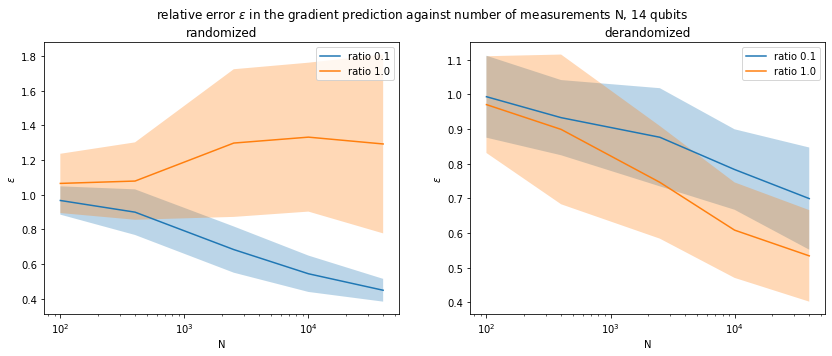

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative error $\epsilon$ in the gradient prediction against number of measurements N, ' + str(qubit_num) + ' qubits')

num_of_measurements = np.array([10, 20, 50, 100, 200])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 200])
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.std(errors, axis=1)
for h in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h,l], label='ratio ' + str(some_ratios[h]))
        axs[l].fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h,l] - rel_error_std[:,h,l], rel_error_mean[:,h,l] + rel_error_std[:,h,l], alpha=0.3)
        axs[l].set( xscale='log', xlabel='N', ylabel='$\epsilon$')
        axs[l].set_title(meas_methods[l])
        axs[l].legend()

In [18]:
# 12 min per batch
# now we estimate the gradient by using the derandomized classical shadows
num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 10 * np.ones(np.size(num_of_measurements))
batches = 20
some_ratios = np.array([0.1, 1.0])
meas_methods = np.array(['randomized', 'derandomized'])
errors_meas_per_rot_const = np.zeros((np.size(num_of_measurements), batches, np.size(some_ratios), np.size(meas_methods)))

for l in range(np.size(meas_methods)):
    if meas_methods[l] == 'derandomized':
        num_of_measurements = 2 * np.ones(np.size(num_of_measurements))
        num_of_measurements_per_rot = (num_of_measurements * num_of_measurements_per_rot) / 2
    for h in range(np.size(some_ratios)):
        param_vec_brute = random_param_vec.clone().detach()
        param_vec_brute.requires_grad_(True)
        mps_brute = MPS.from_tensor_list(tensor_liste_rand)
        mps_brute.from_param_vec(param_vec=param_vec_brute)
        mps_brute.normalise()
        mps_brute.orth_idx = 0
        mps_brute.canonicalise(qubit_num - 1)
        psi = mps_brute.to_state_vector()
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').to_matrix().todense())
        energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        energy_bf.backward()

        for b in range(0, batches):
            print('starting batch ' + str(b))
            for j in range(np.size(num_of_measurements)):
                param_vec_shadow = random_param_vec.clone().detach()
                param_vec_shadow.requires_grad_(True)
                mps = MPS.from_tensor_list(tensor_liste_rand)
                mps.from_param_vec(param_vec=param_vec_shadow)
                mps.normalise()
                mps.orth_idx = 0
                mps.canonicalise(qubit_num - 1)
                observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[j]), int(num_of_measurements_per_rot[j]), meas_methods[l], observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_methods[l])
                energy_shadow = pt.mean(energies)
                energy_shadow.backward()
                errors_meas_per_rot_const[j,b,h,l] = pt.linalg.norm((param_vec_brute.grad - param_vec_shadow.grad) / pt.linalg.norm(param_vec_shadow.grad))

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
star

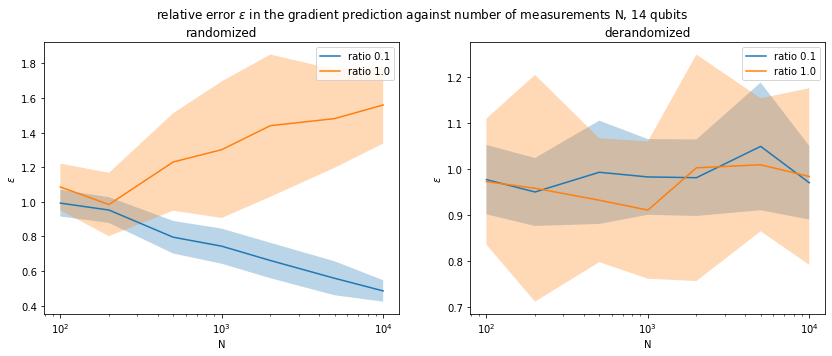

In [19]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative error $\epsilon$ in the gradient prediction against number of measurements N, ' + str(qubit_num) + ' qubits')

num_of_measurements = np.array([10, 20, 50, 100, 200, 500, 1000])
num_of_measurements_per_rot = 10
rel_error_mean = np.mean(errors_meas_per_rot_const, axis=1)
rel_error_std = np.std(errors_meas_per_rot_const, axis=1)
for h in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h,l], label='ratio ' + str(some_ratios[h]))
        axs[l].fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,h,l] - rel_error_std[:,h,l], rel_error_mean[:,h,l] + rel_error_std[:,h,l], alpha=0.3)
        axs[l].set( xscale='log', xlabel='N', ylabel='$\epsilon$')
        axs[l].set_title(meas_methods[l])
        axs[l].legend()

## Gradient Descent with Classical Shadows, comparison to other methods

In [25]:
ratio_h_j = 1.0
qubit_num = 14
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

In [40]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [41]:
# doing gradient descent using brute force
step_num = 500
lr = 0.01
random_param_vec_brute = random_param_vec.clone().detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy_brute = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy_brute[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 500
progress: 2 / 500
progress: 3 / 500
progress: 4 / 500
progress: 5 / 500
progress: 6 / 500
progress: 7 / 500
progress: 8 / 500
progress: 9 / 500
progress: 10 / 500
progress: 11 / 500
progress: 12 / 500
progress: 13 / 500
progress: 14 / 500
progress: 15 / 500
progress: 16 / 500
progress: 17 / 500
progress: 18 / 500
progress: 19 / 500
progress: 20 / 500
progress: 21 / 500
progress: 22 / 500
progress: 23 / 500
progress: 24 / 500
progress: 25 / 500
progress: 26 / 500
progress: 27 / 500
progress: 28 / 500
progress: 29 / 500
progress: 30 / 500
progress: 31 / 500
progress: 32 / 500
progress: 33 / 500
progress: 34 / 500
progress: 35 / 500
progress: 36 / 500
progress: 37 / 500
progress: 38 / 500
progress: 39 / 500
progress: 40 / 500
progress: 41 / 500
progress: 42 / 500
progress: 43 / 500
progress: 44 / 500
progress: 45 / 500
progress: 46 / 500
progress: 47 / 500
progress: 48 / 500
progress: 49 / 500
progress: 50 / 500
progress: 51 / 500
progress: 52 / 500
progress: 53 / 500
pr

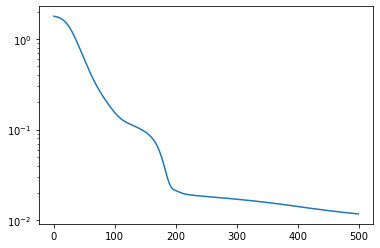

In [42]:
plt.plot(np.arange(0, step_num), accuracy_brute)
plt.yscale('log')

In [43]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [44]:
# doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([1000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 1000
progress: 1 / 500
loss = 1.804288387298584
progress: 2 / 500
loss = 1.7997562885284424
progress: 3 / 500
loss = 1.7679768800735474
progress: 4 / 500
loss = 1.7734445333480835
progress: 5 / 500
loss = 1.762047290802002
progress: 6 / 500
loss = 1.7523642778396606
progress: 7 / 500
loss = 1.720032811164856
progress: 8 / 500
loss = 1.7219114303588867
progress: 9 / 500
loss = 1.6927945613861084
progress: 10 / 500
loss = 1.6742489337921143
progress: 11 / 500
loss = 1.6479827165603638
progress: 12 / 500
loss = 1.6270219087600708
progress: 13 / 500
loss = 1.617931842803955
progress: 14 / 500
loss = 1.5969886779785156
progress: 15 / 500
loss = 1.5689115524291992
progress: 16 / 500
loss = 1.5507248640060425
progress: 17 / 500
loss = 1.5178292989730835
progress: 18 / 500
loss = 1.5092172622680664
progress: 19 / 500
loss = 1.476547360420227
progress: 20 / 500
loss = 1.4642972946166992
progress: 21 / 500
loss = 1.446044683456421
progress: 22 / 500
loss = 1.4274237155914307
pr

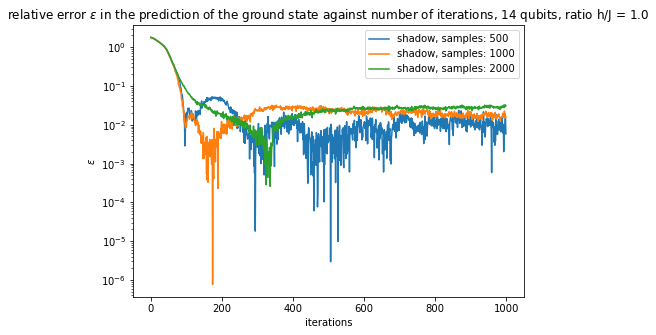

In [11]:
# parameter optimization classical shadows
plt.figure(figsize=(7,5))
for num in range(np.size(num_of_measurements_per_rot)):
    plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_of_measurements_per_rot[num]))
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

Third approach to obtain the gradient:
1.) Measure in the computational basis and obtain indices
2.) obtain the exact amplitudes of these indices
3.) fill these amplitudes/indices into a quantum state
4.) renormalize the quantum state
5.) determine the energy via contraction with Hamiltonian
6.) backpropagation

In [45]:
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [46]:
#sampling brute
step_num = 500
lr = 0.01
num_meas = np.array([1000])
num_unique_ind_brute = np.zeros((np.size(num_meas),step_num))

accuracy_brute_sample = np.zeros((np.size(num_meas), step_num))
for num in range(np.size(num_meas)):
    random_param_vec_brute_sample = random_param_vec.clone().detach()
    random_param_vec_brute_sample.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_brute_sample], lr=lr)
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec = random_param_vec_brute_sample)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas[num])
            num_unique_ind_brute[num, i] = len(indices)
        ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
        psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
        psi[indices] = ampl_direct
        psi = psi / pt.linalg.norm(psi)
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
        energy = psi.conj() @ hamiltonian @ psi
        energy.backward()
        accuracy_brute_sample[num, i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 500
progress: 2 / 500
progress: 3 / 500
progress: 4 / 500
progress: 5 / 500
progress: 6 / 500
progress: 7 / 500
progress: 8 / 500
progress: 9 / 500
progress: 10 / 500
progress: 11 / 500
progress: 12 / 500
progress: 13 / 500
progress: 14 / 500
progress: 15 / 500
progress: 16 / 500
progress: 17 / 500
progress: 18 / 500
progress: 19 / 500
progress: 20 / 500
progress: 21 / 500
progress: 22 / 500
progress: 23 / 500
progress: 24 / 500
progress: 25 / 500
progress: 26 / 500
progress: 27 / 500
progress: 28 / 500
progress: 29 / 500
progress: 30 / 500
progress: 31 / 500
progress: 32 / 500
progress: 33 / 500
progress: 34 / 500
progress: 35 / 500
progress: 36 / 500
progress: 37 / 500
progress: 38 / 500
progress: 39 / 500
progress: 40 / 500
progress: 41 / 500
progress: 42 / 500
progress: 43 / 500
progress: 44 / 500
progress: 45 / 500
progress: 46 / 500
progress: 47 / 500
progress: 48 / 500
progress: 49 / 500
progress: 50 / 500
progress: 51 / 500
progress: 52 / 500
progress: 53 / 500
pr

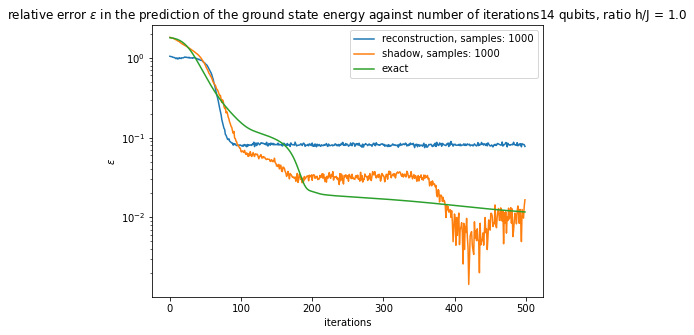

In [47]:
# comparison of all three methods
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), accuracy_brute_sample[num, :], label='reconstruction, samples: ' + str(num_meas[num]))
    plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_meas[num]))
plt.plot(np.arange(0, step_num), accuracy_brute, label='exact')
plt.title('relative error $\epsilon$ in the prediction of the ground state energy against number of iterations' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j))
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

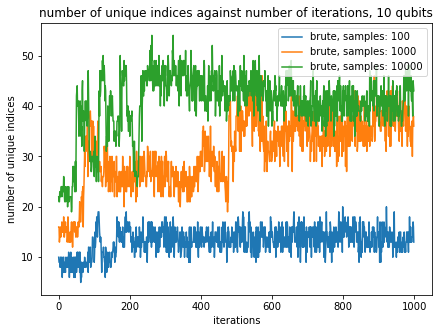

In [160]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), num_unique_ind_brute[num, :], label='brute, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[0, num, :], label='shadow X, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[1, num, :], label='shadow Z, samples: ' + str(num_meas[num]))
plt.xlabel('iterations')
plt.ylabel('number of unique indices')
plt.title('number of unique indices against number of iterations, ' + str(qubit_num) + ' qubits')
#plt.yscale('log')

plt.legend()

### Gradient descent using classical shadows - as many qubits as possible

In [12]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
qubit_num = 22
ratio_h_j = 1.0
save_direc_eigs_max_qubit = Path('data/Diagonal_hamiltonian/eigenvalues_first_max_num_qubits.npy')
energy_dict_max_qubit = np.load(save_direc_eigs_max_qubit, allow_pickle=True)
energy_dict_max_qubit = energy_dict_max_qubit.item()
energy_brute = energy_dict_max_qubit[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
bond_dim = 80
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [13]:
# doing gradient descent using shadows
step_num = 500
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([1000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 1000
progress: 1 / 500
loss = 1.7423046827316284
progress: 2 / 500
loss = 1.7442487478256226
progress: 3 / 500
loss = 1.7408804893493652
progress: 4 / 500
loss = 1.722530722618103
progress: 5 / 500
loss = 1.7222819328308105
progress: 6 / 500
loss = 1.7048031091690063
progress: 7 / 500
loss = 1.7097094058990479
progress: 8 / 500
loss = 1.6757750511169434
progress: 9 / 500
loss = 1.665932536125183
progress: 10 / 500
loss = 1.6450742483139038
progress: 11 / 500
loss = 1.6346957683563232
progress: 12 / 500
loss = 1.6265393495559692
progress: 13 / 500
loss = 1.614244818687439
progress: 14 / 500
loss = 1.5851519107818604
progress: 15 / 500
loss = 1.5670489072799683
progress: 16 / 500
loss = 1.5691148042678833
progress: 17 / 500
loss = 1.524484395980835
progress: 18 / 500
loss = 1.5123999118804932
progress: 19 / 500
loss = 1.501094102859497
progress: 20 / 500
loss = 1.4874720573425293
progress: 21 / 500
loss = 1.4645150899887085
progress: 22 / 500
loss = 1.4658044576644897
p

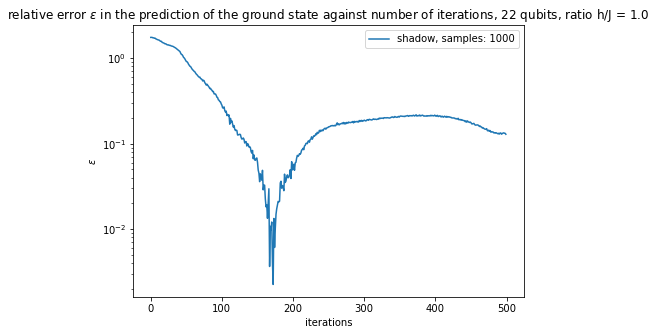

In [14]:

plt.figure(figsize=(7,5))
for num in range(np.size(num_of_measurements_per_rot)):
    plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_of_measurements_per_rot[num]))
plt.title('relative error $\epsilon$ in the prediction of the ground state energy against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

## Gradient Descent classical shadows - plot accuracy in gradient prediction at every iteration step

In [28]:
ratio_h_j = 1.0
qubit_num = 14
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-17.471004054732024


In [29]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [30]:
# doing gradient descent using shadows
step_num = 100
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([1000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
accuracy_grad_pred = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        param_vec_brute = random_param_vec_shadow.clone().detach()
        param_vec_brute.requires_grad_(True)
        mps.from_param_vec(param_vec = param_vec_brute)
        psi = mps.to_state_vector()
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
        energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        energy.backward()
        accuracy_grad_pred[num, i] = pt.linalg.norm((param_vec_brute.grad - random_param_vec_shadow.grad) / pt.linalg.norm(param_vec_brute.grad))
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')
        print(f'grad_pred accuracy = {accuracy_grad_pred[num, i]}')

starting meas_num 1000
progress: 1 / 100
loss = 1.7804030179977417
grad_pred accuracy = 0.3876030722579796
progress: 2 / 100
loss = 1.783250331878662
grad_pred accuracy = 0.19486174038764853
progress: 3 / 100
loss = 1.7678706645965576
grad_pred accuracy = 0.373262691529174
progress: 4 / 100
loss = 1.77488112449646
grad_pred accuracy = 0.23238512043734563
progress: 5 / 100
loss = 1.7662665843963623
grad_pred accuracy = 0.25634115269506424
progress: 6 / 100
loss = 1.752983570098877
grad_pred accuracy = 0.29333542903415877
progress: 7 / 100
loss = 1.7435461282730103
grad_pred accuracy = 0.35865796490054164
progress: 8 / 100
loss = 1.718491554260254
grad_pred accuracy = 0.5234245388418634
progress: 9 / 100
loss = 1.709912657737732
grad_pred accuracy = 0.44378210682668523
progress: 10 / 100
loss = 1.6869760751724243
grad_pred accuracy = 0.529196123119546
progress: 11 / 100
loss = 1.6667917966842651
grad_pred accuracy = 0.6851056809433267
progress: 12 / 100
loss = 1.6353813409805298
grad_pre

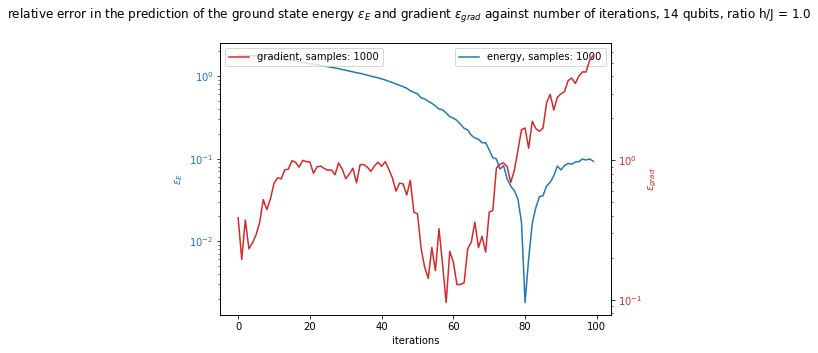

In [37]:
fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle('relative error in the prediction of the ground state energy $\epsilon_E$ and gradient $\epsilon_{grad}$ against number of iterations, ' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )

for num in range(np.size(num_of_measurements_per_rot)):
    color = 'tab:blue'
    axs.plot(np.arange(0, step_num), accuracy[num, :], label='energy, samples: ' + str(num_of_measurements_per_rot[num]), color = color)
    axs.set(yscale = 'log', xlabel='iterations')
    axs.set_ylabel('$\epsilon_E$', color=color)
    axs.tick_params(axis='y', labelcolor=color)
    axs.legend()
    axs2 = axs.twinx()
    color = 'tab:red'
    axs2.plot(np.arange(0,step_num), accuracy_grad_pred[num, :], label='gradient, samples: ' + str(num_of_measurements_per_rot[num]), color = color)
    axs2.set(yscale = 'log')
    axs2.set_ylabel(ylabel='$\epsilon_{grad}$', color = color)
    axs2.tick_params(axis='y', labelcolor=color)
    axs2.legend()


### local energy vs classical shadows

In [4]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
ratio_h_j = 1.0
qubit_num = 14
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [5]:
param_vec_brute = random_param_vec.clone().detach()
mps_brute = MPS.from_tensor_list(tensor_liste_rand)
mps_brute.from_param_vec(param_vec=param_vec_brute)
mps_brute.normalise()
mps_brute.orth_idx = 0
mps_brute.canonicalise(qubit_num - 1)
psi = mps_brute.to_state_vector()
hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
print(energy_bf)

tensor(13.9409+0.j, dtype=torch.complex128)


In [6]:
# precomputations for TFIM
observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
coupling_mask = pt.zeros(len(observables), dtype=pt.int)
phase_mask = pt.zeros(len(observables), dtype=pt.int)
num_y = pt.zeros(len(observables), dtype=pt.int)
coeff = pt.zeros(len(observables), dtype=pt.cdouble)
for i in range(len(observables)):
    for observable_1_loc in observables[i]:
        if observable_1_loc[0] == 'X' or observable_1_loc[0] == 'Y':
            coupling_mask[i] = coupling_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y' or observable_1_loc[0] == 'Z':
            phase_mask[i] = phase_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y':
            num_y[i] = num_y[i] + 1
        if observable_1_loc[0] == 'X':
            coeff[i] = ratio_h_j
        if observable_1_loc[0] == 'Z':
            coeff[i] = 1

In [7]:
def local_energy(samples, coupling_mask, phase_mask, num_y, coeff, mps):
    basis_idx_new = pt.bitwise_xor(samples.unsqueeze(1).expand(-1, coupling_mask.size()[0]), coupling_mask.unsqueeze(0).expand(samples.size()[0], -1))
    num_ones_y_z = pt.bitwise_and(samples.unsqueeze(1).expand(-1, phase_mask.size()[0]), phase_mask.unsqueeze(0).expand(samples.size()[0], -1))
    mask = 2**pt.arange(qubit_num)
    num_ones_y_z = pt.sum(num_ones_y_z.unsqueeze(-1).bitwise_and(mask).ne(0).byte(), dim=2)
    phases = 1j**num_y.unsqueeze(0).expand(samples.size()[0], -1) * (-1)**num_ones_y_z
    ampl_old = MPSQuantumState(qubit_num, mps).amplitude(samples)
    ampl_new = MPSQuantumState(qubit_num, mps).amplitude(basis_idx_new.reshape(pt.prod(pt.tensor(basis_idx_new.size()))))
    ampl_new = ampl_new.reshape((pt.tensor(basis_idx_new.size())[0],pt.tensor(basis_idx_new.size())[1]))
    exp_vals = ampl_new * phases
    e_loc = pt.einsum('ab,b->a', exp_vals, coeff)
    e_loc = e_loc / ampl_old
    return e_loc

In [55]:
# using local energy
param_vec_e_loc = random_param_vec.clone().detach()
mps_e_loc= MPS.from_tensor_list(tensor_liste_rand)
mps_e_loc.from_param_vec(param_vec=param_vec_brute)
mps_e_loc.normalise()
mps_e_loc.orth_idx = 0
mps_e_loc.canonicalise(qubit_num - 1)
num_meas = np.array([1, 2, 5, 10, 20, 50, 100])
batches = 50
errors_e_loc = np.zeros((np.size(num_meas), batches))
num_samples_e_loc = np.zeros((np.size(num_meas), batches))
for b in range(batches):
    for i in range(np.size(num_meas)):
        samples, probs = MPSQuantumState(qubit_num, mps_e_loc).measure(num_meas[i])
        num_samples_e_loc[i, b] = len(samples)
        e_loc = local_energy(pt.tensor(samples), coupling_mask, phase_mask, num_y, coeff, mps_e_loc)
        probab = MPSQuantumState(qubit_num, mps_e_loc).prob(pt.tensor(samples))
        errors_e_loc[i, b] = pt.abs((energy_bf - pt.real(pt.sum(e_loc * probab) / pt.sum(probab))) / energy_bf)

In [56]:
# using unmodified classical shadows
param_vec_shadow = random_param_vec.clone().detach()
mps_shadow = MPS.from_tensor_list(tensor_liste_rand)
mps_shadow.from_param_vec(param_vec=param_vec_brute)
mps_shadow.normalise()
mps_shadow.orth_idx = 0
mps_shadow.canonicalise(qubit_num - 1)
psi_shadow = mps.to_state_vector()
batches = 50
num_meas_shadow = np.array([20, 50, 100, 200, 500, 1000, 2000])
measurement_methods = np.array(['derandomized', 'randomized'])
error_shadow = np.zeros((np.size(num_meas_shadow), batches, np.size(measurement_methods)))
for b in range(batches):
    print('starting batch ' + str(b))
    for l in range(0, 2):
        for n in range(np.size(num_meas_shadow)):
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            measurement_procedure, measurement_index = BFQuantumState(qubit_num, psi_shadow).measurement_shadow(num_meas_shadow[n], measurement_methods[l], observables)
            measurements = conversion_to_prediction_shadow_dict_shape(np.array(measurement_procedure), np.array(measurement_index), qubit_num)
            energy_shadow = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j,
                                                         1, 'open').energy_shadow(None, num_meas_shadow[n], measurement_methods[l], measurements)
            error_shadow[n, b, l] = np.abs((energy_bf - energy_shadow) / energy_bf)

starting batch 0
starting batch 1
starting batch 2
starting batch 3
starting batch 4
starting batch 5
starting batch 6
starting batch 7
starting batch 8
starting batch 9
starting batch 10
starting batch 11
starting batch 12
starting batch 13
starting batch 14
starting batch 15
starting batch 16
starting batch 17
starting batch 18
starting batch 19
starting batch 20
starting batch 21
starting batch 22
starting batch 23
starting batch 24
starting batch 25
starting batch 26
starting batch 27
starting batch 28
starting batch 29
starting batch 30
starting batch 31
starting batch 32
starting batch 33
starting batch 34
starting batch 35
starting batch 36
starting batch 37
starting batch 38
starting batch 39
starting batch 40
starting batch 41
starting batch 42
starting batch 43
starting batch 44
starting batch 45
starting batch 46
starting batch 47
starting batch 48
starting batch 49


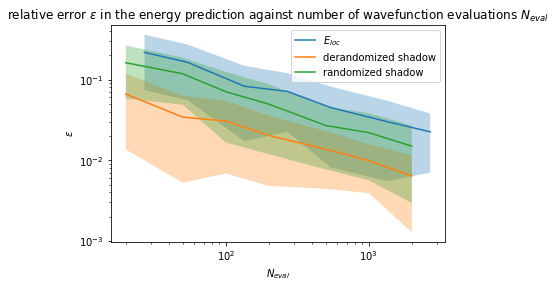

In [57]:
# for E_loc the number of wavefunction evaluations is given by the average number of samples times the number of observables
# for unmodified shadows the number of wavefunction evaluations is given by the number of measurements
num_obs = 2 * qubit_num - 1
num_samples_e_loc_mean = np.mean(num_samples_e_loc, axis=1)
errors_e_loc_mean = np.mean(errors_e_loc, axis=1)
errors_e_loc_std = np.std(errors_e_loc, axis=1)

error_shadow_mean = np.mean(error_shadow, axis=1)
error_shadow_std = np.std(error_shadow, axis=1)

plt.title('relative error $\epsilon$ in the energy prediction against number of wavefunction evaluations $N_{eval}$')
#e_loc
plt.plot(num_obs * num_samples_e_loc_mean, errors_e_loc_mean, label='$E_{loc}$')
plt.fill_between(num_obs * num_samples_e_loc_mean, errors_e_loc_mean - errors_e_loc_std, errors_e_loc_mean + errors_e_loc_std, alpha=0.3)
#shadow
for l in range(0, 2):
    plt.plot(num_meas_shadow, error_shadow_mean[:,l], label=measurement_methods[l] + ' shadow')
    plt.fill_between(num_meas_shadow, error_shadow_mean[:,l] - error_shadow_std[:,l], error_shadow_mean[:,l] + error_shadow_std[:,l], alpha=0.3)
plt.xlabel('$N_{eval}$')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')
plt.legend()